In [67]:
import argparse
import json

from torch.utils.data import DataLoader

from models import *
from utils.datasets import *
from utils.utils import *
import pickle


import argparse
import json

from torch.utils.data import DataLoader

from models import *
from utils.datasets import *
from utils.utils import *


cfg='cfg/yolov3-spp.cfg'
data='/data/zjc4/chipped/xview_data.txt'
weights='weights/model_results.pt'
batch_size=32
img_size=416
conf_thres=0.001
iou_thres=0.25
save_json=True
single_cls=False

'''
def test(cfg,
         data,
         weights=None,
         batch_size=16,
         img_size=416,
         conf_thres=0.001,
         iou_thres=0.5,  # for nms
         save_json=False,
         single_cls=False,
         model=None,
         dataloader=None):
'''
device = torch_utils.select_device('', batch_size=batch_size)
verbose = True
# Remove previous
for f in glob.glob('test_batch*.jpg'):
    os.remove(f)

# Initialize model
model = Darknet(cfg, img_size).to(device)

# Load weights
attempt_download(weights)
if weights.endswith('.pt'):  # pytorch format
    model.load_state_dict(torch.load(weights, map_location=device)['model'])
else:  # darknet format
    load_darknet_weights(model, weights)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
data = parse_data_cfg(data)
nc = 1 if single_cls else int(data['classes'])  # number of classes
path = data['valid']  # path to test images
names = load_classes(data['names'])  # class names
iouv = torch.linspace(0.5, 0.95, 10).to(device)  # iou vector for mAP@0.5:0.95
iouv = iouv[0].view(1)  # comment for mAP@0.5:0.95
niou = iouv.numel()

# Dataloader
if dataloader is None:
    dataset = LoadImagesAndLabels(path, img_size, batch_size, rect=True)
    batch_size = min(batch_size, len(dataset))
    dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            num_workers=min([os.cpu_count(), \
                                             batch_size if batch_size > 1 else 0, 8]),
                            pin_memory=True,
                            collate_fn=dataset.collate_fn)

seen = 0
model.eval()
coco91class = coco80_to_coco91_class()
s = ('%20s' + '%10s' * 6) % ('Class', 'Images', 'Targets', 'P', 'R', 'mAP@0.5', 'F1')
p, r, f1, mp, mr, map, mf1 = 0., 0., 0., 0., 0., 0., 0.
loss = torch.zeros(3)
jdict, stats, ap, ap_class = [], [], [], []
for batch_i, (imgs, targets, paths, shapes) in enumerate(tqdm(dataloader, desc=s)):
    if(batch_i>50):
        break
    imgs = imgs.to(device).float() / 255.0  # uint8 to float32, 0 - 255 to 0.0 - 1.0
    targets = targets.to(device)
    _, _, height, width = imgs.shape  # batch size, channels, height, width

    # Plot images with bounding boxes
    if batch_i == 0 and not os.path.exists('test_batch0.png'):
        plot_images(imgs=imgs, targets=targets, paths=paths, fname='test_batch0.png')


    # Disable gradients
    with torch.no_grad():
        # Run model
        inf_out, train_out = model(imgs)  # inference and training outputs

        # Compute loss
        if hasattr(model, 'hyp'):  # if model has loss hyperparameters
            loss += compute_loss(train_out, targets, model)[1][:3].cpu()  # GIoU, obj, cls

        # Run NMS
        output = non_max_suppression(inf_out, conf_thres=conf_thres, iou_thres=iou_thres)

    # Statistics per image
    for si, pred in enumerate(output):
        labels = targets[targets[:, 0] == si, 1:]
        nl = len(labels)
        tcls = labels[:, 0].tolist() if nl else []  # target class
        seen += 1

        if pred is None:
            if nl:
                stats.append((torch.zeros(0, niou, dtype=torch.bool),
                              torch.Tensor(), torch.Tensor(), tcls))
            continue

        # Append to text file
        # with open('test.txt', 'a') as file:
        #    [file.write('%11.5g' * 7 % tuple(x) + '\n') for x in pred]

        # Clip boxes to image bounds
        clip_coords(pred, (height, width))

        # Append to pycocotools JSON dictionary
        if save_json:
            # [{"image_id": 42, "category_id": 18, "bbox": [258.15, 41.29, 348.26, 243.78],
            # "score": 0.236}, ...
            image_id = int(Path(paths[si]).stem.split('_')[-1])
            box = pred[:, :4].clone()  # xyxy
            # to original shape
            scale_coords(imgs[si].shape[1:], box, shapes[si][0], shapes[si][1])  
            box = xyxy2xywh(box)  # xywh
            box[:, :2] -= box[:, 2:] / 2  # xy center to top-left corner
            for di, d in enumerate(pred):
                jdict.append({'image_id': image_id,
                              'category_id': coco91class[int(d[5])],
                              'bbox': [floatn(x, 3) for x in box[di]],
                              'score': floatn(d[4], 5)})
                pass
            pass

        # Assign all predictions as incorrect
        correct = torch.zeros(len(pred), niou, dtype=torch.bool)
        if nl:
            detected = []  # target indices
            tcls_tensor = labels[:, 0]

            # target boxes
            tbox = \
            xywh2xyxy(labels[:, 1:5]) * torch.Tensor([width, height, width, height]).to(device)

            # Per target class
            for cls in torch.unique(tcls_tensor):
                ti = (cls == tcls_tensor).nonzero().view(-1)  # prediction indices
                pi = (cls == pred[:, 5]).nonzero().view(-1)  # target indices

                # Search for detections
                if len(pi):
                    # Prediction to target ious
                    ious, i = box_iou(pred[pi, :4], tbox[ti]).max(1)  # best ious, indices

                    # Append detections
                    for j in (ious > iouv[0]).nonzero():
                        d = ti[i[j]]  # detected target
                        if d not in detected:
                            detected.append(d)
                            correct[pi[j]] = (ious[j] > iouv).cpu()  # iou_thres is 1xn
                            pass
                        pass
                    pass
        # Append statistics (correct, conf, pcls, tcls)
        stats.append((correct, pred[:, 4].cpu(), pred[:, 5].cpu(), tcls))
        pass
    pass


# Compute statistics
stats = [np.concatenate(x, 0) for x in zip(*stats)]  # to numpy
if len(stats):
    p, r, ap, f1, ap_class = ap_per_class(*stats)
    if niou > 1:
        p, r, ap, f1 = p[:, 0], r[:, 0], ap.mean(1), ap[:, 0]  # [P, R, AP@0.5:0.95, AP@0.5]
    mp, mr, map, mf1 = p.mean(), r.mean(), ap.mean(), f1.mean()
    nt = np.bincount(stats[3].astype(np.int64), minlength=nc)  # number of targets per class
else:
    nt = torch.zeros(1)

# Print results
pf = '%20s' + '%10.3g' * 6  # print format
print(pf % ('all', seen, nt.sum(), mp, mr, map, mf1))

# Print results per class
if verbose and nc > 1 and len(stats):
    for i, c in enumerate(ap_class):
        print(pf % (names[c], seen, nt[c], p[i], r[i], ap[i], f1[i]))

# Save JSON
if save_json and map and len(jdict):
    imgIds = [int(Path(x).stem.split('_')[-1]) for x in dataloader.dataset.img_files]
    with open('results.json', 'w') as file:
        json.dump(jdict, file)

    try:
        from pycocotools.coco import COCO
        from pycocotools.cocoeval import COCOeval
    except:
        print('WARNING: missing pycocotools package, can not compute official COCO mAP.\
        See requirements.txt.')
# Return results
maps = np.zeros(nc) + map
for i, c in enumerate(ap_class):
    maps[c] = ap[i]
#return (mp, mr, map, mf1, *(loss / len(dataloader)).tolist()), maps

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11178MB)
           device1 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11177MB)



               Class    Images   Targets         P         R   mAP@0.5        F1:  43%|████▎     | 51/118 [00:31<00:36,  1.82it/s]

                 all  1.63e+03  1.98e+04    0.0864     0.563     0.414     0.141
                  sa  1.63e+03       938    0.0232    0.0128    0.0075    0.0165
                  la  1.63e+03        50    0.0805      0.72     0.659     0.145
                 veh  1.63e+03  1.64e+04     0.205     0.735     0.587     0.321
                 bus  1.63e+03  1.96e+03    0.0593     0.737     0.395      0.11
                boat  1.63e+03       450    0.0639     0.609      0.42     0.116


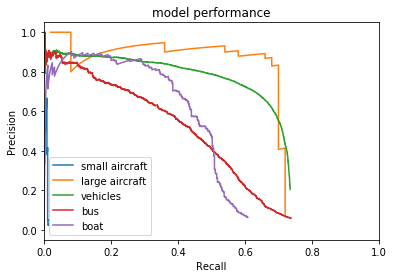

In [72]:
def my_ap_per_class(tp, conf, pred_cls, target_cls):
    """ Compute the average precision, given the recall and precision curves.
    Source: https://github.com/rafaelpadilla/Object-Detection-Metrics.
    # Arguments
        tp:    True positives (nparray, nx1 or nx10).
        conf:  Objectness value from 0-1 (nparray).
        pred_cls: Predicted object classes (nparray).
        target_cls: True object classes (nparray).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """

    # Sort by objectness
    i = np.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

    # Find unique classes
    unique_classes = np.unique(target_cls)

    # Create Precision-Recall curve and compute AP for each class
    s = [len(unique_classes), tp.shape[1]]  # number class, number iou thresholds (i.e. 10 for mAP0.5...0.95)
    ap, p, r = np.zeros(s), np.zeros(s), np.zeros(s)
    for ci, c in enumerate(unique_classes):
        i = pred_cls == c
        n_gt = (target_cls == c).sum()  # Number of ground truth objects
        n_p = i.sum()  # Number of predicted objects

        if n_p == 0 or n_gt == 0:
            continue
        else:
            # Accumulate FPs and TPs
            fpc = (1 - tp[i]).cumsum(0)
            tpc = tp[i].cumsum(0)

            # Recall
            recall = tpc / (n_gt + 1e-16)  # recall curve
            r[ci] = recall[-1]

            # Precision
            precision = tpc / (tpc + fpc)  # precision curve
            p[ci] = precision[-1]

            # AP from recall-precision curve
            for j in range(tp.shape[1]):
                ap[ci, j] = compute_ap(recall[:, j], precision[:, j])

            # Plot
            #fig, ax = plt.subplots(1, 1, figsize=(4, 4))
            #ax.plot(np.concatenate(([0.], recall)), np.concatenate(([0.], precision)))
            #ax.set_title('YOLOv3-SPP'); ax.set_xlabel('Recall'); ax.set_ylabel('Precision')
            #ax.set_xlim(0, 1)
            #fig.tight_layout()
            #fig.savefig('PR_curve.png', dpi=300)
            labels = ["small aircraft","large aircraft","vehicles","bus","boat"]
            plt.plot(recall,precision,label=labels[int(c)])
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title("model performance")
            #plt.title(labels[int(c)])
            plt.xlim(0,1)
            plt.xlim(0,1)
            #plt.show()
            pass
        pass
    plt.legend()
    plt.show()


    # Compute F1 score (harmonic mean of precision and recall)
    f1 = 2 * p * r / (p + r + 1e-16)

    return p, r, ap, f1, unique_classes.astype('int32')

p, r, ap, f1, ap_class = my_ap_per_class(*stats)